In [132]:
import pandas as pd
import numpy as np
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
from pybedtools import BedTool as pbt
import bioframe as bf
from typing import Set, Dict, Any
from collections import Counter
from itertools import chain
from tqdm import tqdm
import os
import re
import json
import time
import seaborn as sns
from typing import Union
import cooler
import bioframe
import cooltools
from os import listdir
from os.path import isfile, join, basename
from io import StringIO
import pickle
import warnings
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

import gseapy as gp
from gseapy import barplot, dotplot
import math
warnings.simplefilter(action='ignore', category=FutureWarning)

### visualization on PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from adjustText import adjust_text

In [133]:
from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
load_dotenv()

True

In [3]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

In [134]:
path_to_mapping = os.getenv('PATH_TO_MAIN_MAPS_MAPPING')
path_to_chromatin_annotation = os.getenv('PATH_TO_CHROMATIN_ANNOTATION')
path_to_gene_coordinates = os.getenv('GENE_COORDINATES')
chrom_size_path = os.getenv('CHROM_SIZE_PATH')
path_to_gene_expression = os.getenv('GENE_EXPRESSION')
path_to_gene_expression_by_brain_region =  os.getenv('GENE_EXPRESSION_BY_BRAIN_REGION')
path_to_loops_clusters_data = "./loops_data/loops_clusters_data"

# 0. Update mapping

In [5]:
mapping = pd.read_feather(f'{path_to_mapping}/main_files_mapping.feather')

short_name_for_plot = {'Ballerino2022_NES_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'NES Ballerino',
 'Ballerino2022_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'NPC Ballerino',
 'Ballerino2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Ballerino',
 'Heffel_2T_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Heffel (2T)',
 'Heffel_3T_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Heffel (3T)',
 'Heffel_adult_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Heffel',
 'Heffel_infant_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Heffel (infant)',
 'Hu2021_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Hu',
 'Our_data_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Our data\n(iPSC-derived\nneurons)',
 'Li2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Li',
 'Pletenev2024_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Our data\n(Post-mortem\nneurons)',
 'Rajarajan_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Rajarajan',
 'Rahman2023_FetalBrain_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Rahman\n(Fetal\nneurons)',
 'Rahman2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Rahman\n(Post-mortem\nneurons)',
 'Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Rahman\n(iPSC-derived\nneurons)',
 'Rajarajan_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'NPC Rajarajan',
 'Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Tian',
 'Wu2021_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Wu',
 'Zaghi2023_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'NPC Zaghi',
 'Zaghi2023_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed': 'Zaghi'}

In [6]:
LIST1 = list(short_name_for_plot.keys())
LIST2 = mapping.sample_map.tolist()

samples_list1 = {}
for fname in LIST1:
    sample = fname.split('_sampled_')[0]
    samples_list1[sample] = fname

samples_list2 = {}
for fname in LIST2:
    sample = fname.split('.drop_diag.5kb')[0].split('.sampled_exact.mcool')[0].split('.3056_')[0].split('.EN_IN.29')[0]
    samples_list2[sample] = fname

mapping2 = {}
for sample in samples_list1:
    if sample in samples_list2:
        fname1 = samples_list1[sample]
        fname2 = samples_list2[sample]
        mapping2[fname2] = fname1
    else:
        print(f"Sample {sample} not found in LIST2")

In [7]:
mapping['loop_file'] = mapping.sample_map.map(mapping2)
mapping['short_name_for_plot'] = mapping.loop_file.map(short_name_for_plot)
mapping.to_pickle('./loops_data/mapping_with_loops.pickle')

# 1. Load files

In [8]:
name_appender = ""
save_name = "loops_clustering_post_mortem_vs_iPSC_derived"
path_to_loops_clusters_data = "./loops_data/loops_clusters_data"
merged_all_clusters = pd.read_pickle(f"{path_to_loops_clusters_data}/{save_name}_calculated_clusters_all{name_appender}.pickle")

In [16]:
clusters_is_loop= pd.read_pickle(f"{path_to_loops_clusters_data}/{save_name}_calculated_clusters_all_withLoopNotation_withCentral.pickle")
clusters_only_loops = clusters_is_loop.loc[~(clusters_is_loop.intensity_median.isna()) & (clusters_is_loop.is_loop_loop_ratio == True) & (clusters_is_loop.is_loop_loop_central == True)]
clusters_only_loops['is_loop'] = True

/tmp/ipykernel_398285/1084263119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_only_loops['is_loop'] = True


In [17]:
merged_all_clusters = merged_all_clusters.merge(clusters_only_loops[['source', 'cluster','is_loop']].drop_duplicates(), on = ["source", 'cluster'], how= "left")
merged_all_clusters.is_loop = merged_all_clusters.is_loop.fillna(False)

In [18]:
merged_all_clusters['short_name']  =merged_all_clusters.source.map(dict(mapping[['loop_file', 'sample_init']].values))
merged_all_clusters['short_name_for_plot'] = merged_all_clusters.source.map(dict(mapping[['loop_file', 'short_name_for_plot']].values))
merged_all_clusters['short_name_for_plot'].unique()

array(['Tian', 'Zaghi', 'Wu', 'Rahman\n(iPSC-derived\nneurons)',
       'Rajarajan', 'Our data\n(Post-mortem\nneurons)', 'Heffel',
       'Rahman\n(Post-mortem\nneurons)',
       'Our data\n(iPSC-derived\nneurons)', 'Ballerino', 'Li', 'Hu'],
      dtype=object)

In [19]:
merged_all_clusters_stats_trueLoops = merged_all_clusters[merged_all_clusters.is_loop == True]

# 2. Prepare connection with other data types

In [20]:
def bedpe_to_bed(df: pd.DataFrame, ann_col: str = 'loop_num', slop: Union[int, bool] = False) -> pd.DataFrame:
    """
    Extract unique BED regions from a BEDPE dataframe. Index is ignored.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing BEDPE data with columns 
      'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', and the annotation column.
    - ann_col (str): Column name for annotations, default is 'loop_num'.
    - slop (int or bool): Amount to extend the start and end positions. If False, no extension is applied.

    Returns:
    - pd.DataFrame: DataFrame containing unique BED regions.
    """
    required_columns = {'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', ann_col}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input DataFrame must contain the columns: {required_columns}")

    if not isinstance(slop, (int, bool)):
        raise TypeError("Slop must be an integer or a boolean.")

    df_region1 = df[['chrom1', 'start1', 'end1', ann_col]].copy()
    df_region1['anchor'] = 'left_anchor'
    df_region2 = df[['chrom2', 'start2', 'end2', ann_col]].copy()
    df_region2['anchor'] = 'right_anchor'

    df_region1.columns = df_region1.columns.str.replace('1', '')
    df_region2.columns = df_region2.columns.str.replace('2', '')

    df_bed = pd.concat([df_region1, df_region2], ignore_index=True).drop_duplicates(ignore_index=True)

    if slop:
        df_bed['start'] = (df_bed['start'] - slop).clip(lower=0).astype(int)  # Ensure non-negative start
        df_bed['end'] = (df_bed['end'] + slop).astype(int)

    return df_bed


## 2.1 Gene annotation

In [21]:
### Gene annotation
chromatin_annotation = pd.read_pickle(f'{path_to_chromatin_annotation}/chromatin_annotation.feather')
promoters = chromatin_annotation[chromatin_annotation.type == "promoters"].reset_index(drop=True)
genes = chromatin_annotation[chromatin_annotation.type == "gene"].reset_index(drop=True)

def intersection_with_gene_annotation(merged_all_clusters, genes):
    clusters_allStats_bed = bedpe_to_bed(merged_all_clusters, ann_col ='cluster', slop=15000*1)
    genes_in_clusters = bf.overlap(genes, clusters_allStats_bed, how='left', suffixes=('','_anno'))
    genes_in_clusters = genes_in_clusters[['gene_name', 'gene_type','cluster_anno']].rename(columns = {'cluster_anno':'cluster'})
    genes_in_clusters.drop_duplicates(inplace=True)
    merged_all_clusters = merged_all_clusters.merge(genes_in_clusters, how='left', on = 'cluster')
    merged_all_clusters.rename(columns = {'gene_name':'gene_name_anno', 'gene_type':'gene_type_anno'}, inplace=True)
    return merged_all_clusters
    

## 2.2. Intersection with H3K27me3

In [22]:

def bedpe_to_bed_multiple_cols(df, ann_cols = ['num'], slope=0):
    """
    Extract unique bed regions from bedpe dataframe. Index is ignored.
    """
    df_reg1 = df[['chrom1', 'start1', 'end1'] + ann_cols].copy()
    df_reg1['anchor'] = 'left_anh'
    df_reg2 = df[['chrom2', 'start2', 'end2']+ann_cols ].copy()
    df_reg2['anchor'] = 'right_anh'
    df_reg1.columns = df_reg1.columns.str.rstrip('1')
    df_reg2.columns = df_reg2.columns.str.rstrip('2')

    df_bed = pd.concat([df_reg1, df_reg2], ignore_index=True)\
               .drop_duplicates(ignore_index=True)  
    df_bed.start = df_bed.start-slope
    df_bed.end = df_bed.end+slope
    return df_bed 

def get_overlap_with_h3k27me3(df1, h3k27me3_encode, column_new_name, factor_slop = 0):
    
    df1 = df1.drop_duplicates()
    df1.start =df1.start - 15000 *factor_slop
    df1.end =df1.end + 15000  *factor_slop
    df1.start = df1.start.astype(int)
    df1.end = df1.end.astype(int)

    df1_h3k27me3_encode = bf.overlap(df1, h3k27me3_encode, how='left', suffixes=('','_anno'))
    df1_h3k27me3_encode[f'{column_new_name}_temp']  = df1_h3k27me3_encode['start_anno'].apply(lambda x: True if isinstance(x, int) else False)
    anchor_status_all, anchor_status_general = get_peak_status(df1_h3k27me3_encode, f'{column_new_name}_temp')
    df1_h3k27me3_encode[f'{column_new_name}_anchor'] = df1_h3k27me3_encode['cluster'].map(anchor_status_all)
    df1_h3k27me3_encode[column_new_name] = df1_h3k27me3_encode['cluster'].map(anchor_status_general)
    df1_h3k27me3_encode.drop(columns = f'{column_new_name}_temp', inplace=True)    
    
    df1_h3k27me3_encode.start =df1_h3k27me3_encode.start + 15000 *factor_slop
    df1_h3k27me3_encode.end =df1_h3k27me3_encode.end - 15000  *factor_slop
    df1_h3k27me3_encode.start = df1_h3k27me3_encode.start.astype(int)
    df1_h3k27me3_encode.end = df1_h3k27me3_encode.end.astype(int)
    assert df1.cluster.nunique() == df1_h3k27me3_encode.cluster.nunique()
    return df1_h3k27me3_encode 


def get_peak_status(up_postmortem_mu_h3k27me3, column_new_name):
    anchor_status_all = {}
    anchor_status_general = {}
    grouped = up_postmortem_mu_h3k27me3.groupby(['cluster', 'anchor'])[column_new_name].sum().unstack(fill_value=0)
    print('Getting peak status...')

    for cluster, row in tqdm(grouped.iterrows()):
        left_anh = row.get('left_anh', 0)
        right_anh = row.get('right_anh', 0)

        if right_anh > 0 and left_anh > 0:
            anchor_status_all[cluster] = 'both'
            anchor_status_general[cluster] = True
        elif right_anh > 0 or left_anh > 0:
            anchor_status_all[cluster] = 'one_anh'
            anchor_status_general[cluster] = True
        else:
            anchor_status_all[cluster] = 'none'
            anchor_status_general[cluster] = False

    assert len(anchor_status_all) == up_postmortem_mu_h3k27me3['cluster'].nunique()
    assert len(anchor_status_general) == up_postmortem_mu_h3k27me3['cluster'].nunique()
    print('Done')
    return anchor_status_all, anchor_status_general


In [23]:
def intersection_with_h3k27me3(merged_all_clusters, h3k27me3_encode, h3k27me3_post_mortem):
    
    merged_all_clusters_bed = bedpe_to_bed_multiple_cols(merged_all_clusters, ann_cols =['cluster'], slope=0)
    merged_all_clusters_stats_h3k27me3_encode = get_overlap_with_h3k27me3(merged_all_clusters_bed, h3k27me3_encode, 'has_h3k27me3_peak_encode', factor_slop = 1.5)
    merged_all_clusters_stats_h3k27me3_kz = get_overlap_with_h3k27me3(merged_all_clusters_bed, h3k27me3_post_mortem, 'has_h3k27me3_peak_kozlenkov', factor_slop = 1.5)
    assert merged_all_clusters_stats_h3k27me3_encode.cluster.nunique() == merged_all_clusters.cluster.nunique()
    assert merged_all_clusters_stats_h3k27me3_kz.cluster.nunique() == merged_all_clusters.cluster.nunique()

    init_cluster_number = merged_all_clusters.cluster.nunique()
    assert  'has_h3k27me3_peak_encode' in merged_all_clusters_stats_h3k27me3_encode.columns.tolist()
    assert  'has_h3k27me3_peak_kozlenkov' in merged_all_clusters_stats_h3k27me3_kz.columns.tolist()

    
    merged_all_clusters = merged_all_clusters.merge(merged_all_clusters_stats_h3k27me3_encode[['cluster', 'has_h3k27me3_peak_encode_anchor', 'has_h3k27me3_peak_encode']].drop_duplicates(), on = ['cluster'], how='left')
    merged_all_clusters = merged_all_clusters.merge(merged_all_clusters_stats_h3k27me3_kz[['cluster', 'has_h3k27me3_peak_kozlenkov_anchor', 'has_h3k27me3_peak_kozlenkov']].drop_duplicates(), on = ['cluster'], how='left')
    assert  'has_h3k27me3_peak_encode' in merged_all_clusters.columns.tolist()
    assert  'has_h3k27me3_peak_kozlenkov' in merged_all_clusters.columns.tolist()

    assert  merged_all_clusters.cluster.nunique() == init_cluster_number

    merged_all_clusters['h3k27me3_peak_status_kozlenkov'] = merged_all_clusters.has_h3k27me3_peak_kozlenkov.apply(lambda x: "has h3k27me3 peak" if x  else 'do not have h3k27me3 peak')
    merged_all_clusters['h3k27me3_peak_status_encode'] = merged_all_clusters.has_h3k27me3_peak_encode.apply(lambda x: "has h3k27me3 peak" if x  else 'do not have h3k27me3 peak')
    return merged_all_clusters


In [24]:
path_to_cultural_h3k27me3 = os.getenv('PATH_TO_CULTURAL_H3K27ME3')
path_to_postmortal_h3k27me3 = os.getenv('PATH_TO_POSTMORTAL_H3K27ME3')
### H3K27me3
### ENCODE h3k27me3 source for iPSC-derived

h3k27me3_encode = pd.read_csv(f'{path_to_cultural_h3k27me3}/ChIP-seq.H3K27me3.neurons.peaks.ENCFF104DEP.bed', sep = '\t', header = None)
h3k27me3_encode = h3k27me3_encode[h3k27me3_encode[8]>= 2]
h3k27me3_encode.columns = ['chrom', 'start', 'end',  'score', 'score1', 'score2', 'score3', 'score4', 'score5', 'score6']
h3k27me3_encode.shape

### Kozlenkov h3k27me3 source for post-mortem
h3k27me3_post_mortem = pd.read_csv(f'{path_to_postmortal_h3k27me3}/kozlenkov2018_merged_h3k27me3.bed',sep="\t" ,header=None)
h3k27me3_post_mortem.columns = ['chrom', 'start', 'end']
print(h3k27me3_encode.shape, h3k27me3_post_mortem.shape)

(15290, 10) (15594, 3)


## 2.3 TFs

In [25]:
path_to_tfs = os.getenv('PATH_TO_TFS')
tfs = pd.read_csv(f"{path_to_tfs}/DatabaseExtract_v_1.01.csv")
tfs = tfs[tfs['Is TF?']=="Yes"]
tfs = set(tfs['HGNC symbol'].tolist())
len(tfs)

1639

In [26]:
def intersection_with_human_tfs(merged_all_clusters, tfs):
    cluster_to_tfs = {}
    df_grouped = merged_all_clusters.groupby("cluster")
    for cluster, group in tqdm(df_grouped):
        if tfs.intersection(group.gene_name_anno):
            cluster_to_tfs[cluster] = True
        else:
             cluster_to_tfs[cluster] = False        
    merged_all_clusters['tf_in_cluster'] = merged_all_clusters.cluster.map(cluster_to_tfs)
    merged_all_clusters['tf_in_cluster_status'] = merged_all_clusters.tf_in_cluster.apply(lambda x: "contains TF" if x else "no TFs")
    return merged_all_clusters


## 2.4. Intersection with polycomb dots

In [27]:
def bedpe_to_bed(df, ann_col ='loop_num', slop=False):
    """
    Extract unique bed regions from bedpe dataframe. Index is ignored.
    """
    df_reg1 = df[['chrom1', 'start1', 'end1', ann_col]].copy()
    df_reg1['anchor'] = 'left_anh'
    df_reg2 = df[['chrom2', 'start2', 'end2', ann_col]].copy()
    df_reg2['anchor'] = 'right_anh'
    df_reg1.columns = df_reg1.columns.str.rstrip('1')
    df_reg2.columns = df_reg2.columns.str.rstrip('2')

    df_bed = pd.concat([df_reg1, df_reg2], ignore_index=True)\
               .drop_duplicates(ignore_index=True)    
    if slop:
        df_bed.start = df_bed.start - slop
        df_bed.start = df_bed.start.astype(int)
        df_bed.end = df_bed.end + slop
        df_bed.end = df_bed.end.astype(int)

    return df_bed 


def intersection_with_polycomb_dots(merged_all_clusters_stats_trueLoops, pair_sites_bed):    
    merged_all_clusters_stats_trueLoops_bed = bedpe_to_bed(merged_all_clusters_stats_trueLoops, ann_col ='cluster', slop=15000*1)
    polycombDots_in_clusters = bf.overlap(merged_all_clusters_stats_trueLoops_bed, pair_sites_bed, how='left', suffixes=('','_polycombDots'))
    
    groupped_pol = polycombDots_in_clusters[["cluster", 'chrom_polycombDots']].groupby("cluster")
    updated = {}
    for row in groupped_pol:
        all_status = row[1].chrom_polycombDots.tolist()
        if any(e != None for e in  all_status):
            updated[row[0]] = True
        else:
            updated[row[0]] = False
    polycombDots_in_clusters_status, _ = get_peak_polycomb_dots_status(polycombDots_in_clusters)

    
    merged_all_clusters_stats_trueLoops['has_polycombDot_anchor'] = merged_all_clusters_stats_trueLoops.cluster.map(updated)
    merged_all_clusters_stats_trueLoops['has_polycombDot_anchor_status_detailed'] = merged_all_clusters_stats_trueLoops.cluster.map(polycombDots_in_clusters_status)
    
    return merged_all_clusters_stats_trueLoops, polycombDots_in_clusters


def get_peak_polycomb_dots_status(polycombDots_in_clusters):
    anchor_status_all = {}
    anchor_status_general = {}
    grouped = polycombDots_in_clusters.groupby(['cluster', 'anchor'])["chrom_polycombDots"].sum().unstack(fill_value=0)
    print('Getting peak status...')

    for cluster, row in tqdm(grouped.iterrows()):
        left_anh = row.get('left_anh', 0)
        right_anh = row.get('right_anh', 0)
        if isinstance(right_anh , str) and isinstance(left_anh , str):
            anchor_status_all[cluster] = 'both'
            anchor_status_general[cluster] = True
        elif isinstance(right_anh , str) or isinstance(left_anh , str):
            anchor_status_all[cluster] = 'one_anh'
            anchor_status_general[cluster] = True
        else:
            anchor_status_all[cluster] = 'none'
            anchor_status_general[cluster] = False

    assert len(anchor_status_all) == polycombDots_in_clusters['cluster'].nunique()
    assert len(anchor_status_general) == polycombDots_in_clusters['cluster'].nunique()
    print('Done')
    return anchor_status_all, anchor_status_general
    


In [28]:
path_to_polycomb_dots = os.getenv('PATH_TO_POLYCOMB_DOTS')
path_to_up_genes_cultures_vs_postmortem = os.getenv('PATH_TO_UP_GENES_CULTURES_VS_POSTMORTEM')
path_to_down_genes_cultures_vs_postmortem = os.getenv('PATH_TO_DOWN_GENES_CULTURES_VS_POSTMORTEM')
pair_sites = pd.read_csv(f"{path_to_polycomb_dots}/pair_sites_polycomb_dot_anchors.csv")
pair_sites['num'] = [i for i in range(pair_sites.shape[0])]
pair_sites_bed = bedpe_to_bed(pair_sites, ann_col ='num', slop=0)

## 2.5. Intersection with DEG

In [29]:
def intersection_with_deg(
    merged_all_clusters_stats_trueLoops: pd.DataFrame,
    intersected_genes_dwn_set: Set[str],
    intersected_genes_up_set: Set[str],
    gene_column: str = "gene_name_anno"
) -> pd.DataFrame:
    
    if gene_column not in merged_all_clusters_stats_trueLoops.columns:
        raise ValueError(f"The specified gene column '{gene_column}' does not exist in the DataFrame.")

    status_genes: Dict[Any, str] = {}
    up_down_genes_for_cluster: Dict[Any, Dict[str, list]] = {}

    deduplicated_df = merged_all_clusters_stats_trueLoops[[gene_column, "cluster"]].drop_duplicates()

    for cluster, df in deduplicated_df.groupby('cluster'):
        gene_set = set(df[gene_column])
        down_genes = gene_set & intersected_genes_dwn_set
        up_genes = gene_set & intersected_genes_up_set
        
        up_down_genes_for_cluster[cluster] = {
            "up": list(up_genes),
            "down": list(down_genes)
        }

        if up_genes and down_genes:
            status_genes[cluster] = "Up and Down genes"
        elif up_genes:
            status_genes[cluster] = "Up genes"
        elif down_genes:
            status_genes[cluster] = "Down genes"
        else:
            status_genes[cluster] = "no changed gene"
    
    merged_all_clusters_stats_trueLoops['diff_genes_status'] = merged_all_clusters_stats_trueLoops['cluster'].map(status_genes)
    
    return merged_all_clusters_stats_trueLoops

In [30]:
up_genes_cultures_vs_postmortem = pd.read_pickle(path_to_up_genes_cultures_vs_postmortem+ "genes_up_postmortem_vs_cultures.pickle")
down_genes_cultures_vs_postmortem = pd.read_pickle(path_to_down_genes_cultures_vs_postmortem+ "genes_dwn_postmortem_vs_cultures.pickle")
up_genes_cultures_vs_postmortem_set = set(up_genes_cultures_vs_postmortem[0].tolist())
down_genes_cultures_vs_postmortem_set = set(down_genes_cultures_vs_postmortem[0].tolist())


gene_annotation = pd.read_pickle(f'{path_to_gene_coordinates}/gene_annotation_gencodeV38Basic.pickle')
gene_annotation.rename(columns = {'Chromosome':'chrom','Start':'start', 'End':'end'}, inplace=True)
gene_annotation = gene_annotation[['chrom', 'start', 'end','gene_name', 'gene_id', 'Strand',  'gene_type']]
chrom_sizes_path = f'{chrom_size_path}/chrom.sizes'
tss = pbt.from_dataframe(gene_annotation).flank(g=chrom_sizes_path, s=True, l=1, r=0)
tss = pd.read_table(tss.fn, header = None, names=gene_annotation.columns.tolist())
tss.to_pickle(f'{path_to_gene_coordinates}/tss_gene_annotation_gencodeV38Basic_all.pickle')
tss.gene_name.nunique(), gene_annotation.gene_name.nunique()


(59385, 59385)

## 2.6. Intersection with gene promoters

In [31]:
def intersection_with_promoters(merged_all_clusters_stats, promoters, slop_factor =15000*1 ):
    clusters_allStats_bed = bedpe_to_bed(merged_all_clusters_stats, ann_col ='cluster', slop=slop_factor)
    promoters_in_clusters = bf.overlap(promoters, clusters_allStats_bed, how='left', suffixes=('','_promoters'))
    promoters_in_clusters = promoters_in_clusters[['gene_name', 'gene_type','cluster_promoters']].rename(columns = {'gene_name':'gene_name_promoter','gene_type':'gene_type_promoter','cluster_promoters':'cluster'})
    promoters_in_clusters.drop_duplicates(inplace=True)
    merged_all_clusters_stats = merged_all_clusters_stats.merge(promoters_in_clusters, how='left', on = 'cluster')
    return merged_all_clusters_stats

## 2.7. Intersection with  H3K27me3

In [32]:
def intersection_with_h3k27me3(merged_all_clusters, h3k27me3_encode, h3k27me3_post_mortem):
    
    merged_all_clusters_bed = bedpe_to_bed_multiple_cols(merged_all_clusters, ann_cols =['cluster'], slope=0)
    merged_all_clusters_stats_h3k27me3_encode = get_overlap_with_h3k27me3(merged_all_clusters_bed, h3k27me3_encode, 'has_h3k27me3_peak_encode', factor_slop = 1.5)
    merged_all_clusters_stats_h3k27me3_kz = get_overlap_with_h3k27me3(merged_all_clusters_bed, h3k27me3_post_mortem, 'has_h3k27me3_peak_kozlenkov', factor_slop = 1.5)
    assert merged_all_clusters_stats_h3k27me3_encode.cluster.nunique() == merged_all_clusters.cluster.nunique()
    assert merged_all_clusters_stats_h3k27me3_kz.cluster.nunique() == merged_all_clusters.cluster.nunique()

    init_cluster_number = merged_all_clusters.cluster.nunique()
    assert  'has_h3k27me3_peak_encode' in merged_all_clusters_stats_h3k27me3_encode.columns.tolist()
    assert  'has_h3k27me3_peak_kozlenkov' in merged_all_clusters_stats_h3k27me3_kz.columns.tolist()

    
    merged_all_clusters = merged_all_clusters.merge(merged_all_clusters_stats_h3k27me3_encode[['cluster', 'has_h3k27me3_peak_encode_anchor', 'has_h3k27me3_peak_encode']].drop_duplicates(), on = ['cluster'], how='left')
    merged_all_clusters = merged_all_clusters.merge(merged_all_clusters_stats_h3k27me3_kz[['cluster', 'has_h3k27me3_peak_kozlenkov_anchor', 'has_h3k27me3_peak_kozlenkov']].drop_duplicates(), on = ['cluster'], how='left')
    assert  'has_h3k27me3_peak_encode' in merged_all_clusters.columns.tolist()
    assert  'has_h3k27me3_peak_kozlenkov' in merged_all_clusters.columns.tolist()

    assert  merged_all_clusters.cluster.nunique() == init_cluster_number

    merged_all_clusters['h3k27me3_peak_status_kozlenkov'] = merged_all_clusters.has_h3k27me3_peak_kozlenkov.apply(lambda x: "has h3k27me3 peak" if x  else 'do not have h3k27me3 peak')
    merged_all_clusters['h3k27me3_peak_status_encode'] = merged_all_clusters.has_h3k27me3_peak_encode.apply(lambda x: "has h3k27me3 peak" if x  else 'do not have h3k27me3 peak')
    return merged_all_clusters


In [33]:
merged_all_clusters_stats_trueLoops = intersection_with_gene_annotation(merged_all_clusters_stats_trueLoops, genes)
merged_all_clusters_stats_trueLoops = intersection_with_h3k27me3(merged_all_clusters_stats_trueLoops, h3k27me3_encode,h3k27me3_post_mortem)
merged_all_clusters_stats_trueLoops = intersection_with_human_tfs(merged_all_clusters_stats_trueLoops, tfs)
merged_all_clusters_stats_trueLoops, polycombDots_in_clusters = intersection_with_polycomb_dots(merged_all_clusters_stats_trueLoops, pair_sites_bed)
merged_all_clusters_stats_trueLoops = intersection_with_deg(merged_all_clusters_stats_trueLoops, down_genes_cultures_vs_postmortem_set, up_genes_cultures_vs_postmortem_set)
merged_all_clusters_stats_trueLoops = intersection_with_promoters(merged_all_clusters_stats_trueLoops, promoters)
merged_all_clusters_stats_trueLoops.cluster.nunique()

Getting peak status...


19697it [00:00, 21015.50it/s]


Done
Getting peak status...


19697it [00:00, 22864.31it/s]


Done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19697/19697 [00:01<00:00, 13748.83it/s]


Getting peak status...


19697it [00:00, 21146.94it/s]


Done


19697

In [34]:
merged_all_clusters_stats_trueLoops.to_pickle(f"./loops_data/loops_clusters_processed_files/{save_name}_trueLoops_Properties.pickle")

## 2.7 Intersection for all clusters

In [35]:
merged_all_clusters = intersection_with_gene_annotation(merged_all_clusters, genes)
merged_all_clusters = intersection_with_h3k27me3(merged_all_clusters, h3k27me3_encode,h3k27me3_post_mortem)
merged_all_clusters= intersection_with_human_tfs(merged_all_clusters, tfs)
merged_all_clusters, polycombDots_in_clusters = intersection_with_polycomb_dots(merged_all_clusters, pair_sites_bed)
merged_all_clusters = intersection_with_deg(merged_all_clusters, down_genes_cultures_vs_postmortem_set, up_genes_cultures_vs_postmortem_set)
merged_all_clusters = intersection_with_promoters(merged_all_clusters, promoters)
merged_all_clusters.cluster.nunique()
all(merged_all_clusters.columns == merged_all_clusters_stats_trueLoops.columns)

Getting peak status...


22235it [00:01, 20917.95it/s]


Done
Getting peak status...


22235it [00:00, 22477.71it/s]


Done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22235/22235 [00:02<00:00, 10920.93it/s]


Getting peak status...


22235it [00:01, 20252.25it/s]


Done


True

In [36]:
merged_all_clusters.to_pickle(f"./loops_data/loops_clusters_processed_files/{save_name}_merged_all_clusters_Properties.pickle")

## 2.8. General info

In [37]:
def create_group(merged_all_clusters):
    samples2groups =  {i:"iPSC-derived neurons" if "iPSC" in i else "Post-mortem neurons" for i in merged_all_clusters.source.unique()}
    merged_all_clusters['group'] = merged_all_clusters['source'].map(samples2groups)
    return merged_all_clusters

def create_length(merged_all_clusters_with_importance):
    merged_all_clusters_with_importance['length'] = merged_all_clusters_with_importance['end2'] - merged_all_clusters_with_importance["end1"]
    merged_all_clusters_with_importance['length_kb'] = merged_all_clusters_with_importance['length']/1000
    return merged_all_clusters_with_importance
    
merged_all_clusters_stats_trueLoops = create_length(merged_all_clusters_stats_trueLoops)
merged_all_clusters_stats_trueLoops = create_group(merged_all_clusters_stats_trueLoops)

merged_all_clusters = create_length(merged_all_clusters)
merged_all_clusters = create_group(merged_all_clusters)

## 2.9. Log2FC ratio

In [52]:
def create_dataframe_ratios(merged_all_clusters_stats, all_expression_sources = False, gene_column = "gene_name_anno"):
    groupped = merged_all_clusters_stats[['cluster', 'group', 'intensity_median']].groupby(['cluster', 'group']).median()
    log2FC_log2rloops = groupped.reset_index().sort_values(['cluster', 'group'])
    

    log2FC_log2rloops['ratio'] = log2FC_log2rloops.groupby('cluster')['intensity_median'].transform(lambda x: x.iloc[0] / (x.iloc[1] + np.finfo(float).eps))
    log2FC_log2rloops['log2_ratio'] = np.log2(log2FC_log2rloops['ratio'])
    log2FC_log2rloops['status'] = log2FC_log2rloops.groupby('cluster')['intensity_median'].transform(lambda x:'remove' if x.iloc[0] == 0 and x.iloc[1]==0  else 'retain')
    
    log2FC_log2rloops = log2FC_log2rloops.merge(merged_all_clusters_stats[['cluster', gene_column]].drop_duplicates(), on ='cluster', how="left")
    log2FC_log2rloops.rename(columns = {gene_column:'gene_name'}, inplace=True)
    if all_expression_sources:
        log2FC_log2rloops = log2FC_log2rloops.merge(all_expression_genes, on ='gene_name', how="left")
    else:
        log2FC_log2rloops = log2FC_log2rloops.merge(all_expression_genes_medians, on ='gene_name', how="left")
    log2FC_log2rloops = log2FC_log2rloops.merge(merged_all_clusters_stats[['cluster','tf_in_cluster','has_h3k27me3_peak_kozlenkov_anchor', 'has_polycombDot_anchor', 'h3k27me3_peak_status_kozlenkov']].drop_duplicates(), on = 'cluster', how='left')
    
    
    df_filtered2 = log2FC_log2rloops[log2FC_log2rloops.status == 'retain']
    df_filtered2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_filtered2.dropna(subset=["ratio"], how="all", inplace=True)
    df_filtered2.dropna(subset=["log2_ratio"], how="all", inplace=True)
    
    df_deduplicated = df_filtered2[['cluster','log2FoldChange', 'log2_ratio']].drop_duplicates().groupby('cluster').median().reset_index()
    df_deduplicated.columns = ['cluster','log2FoldChange_median', 'log2_ratio']
    df_filtered2 = df_filtered2.merge(df_deduplicated[['cluster', 'log2FoldChange_median']].drop_duplicates(), on = 'cluster', how='left')
    
    df_filtered2['tf_in_cluster_status'] = df_filtered2.tf_in_cluster.apply(lambda x: "contains TF" if x else "no TFs")
    df_filtered2['has_polycombDot_anchor_status'] = df_filtered2.has_polycombDot_anchor.apply(lambda x: "contains polycomb dots anchor" if x else "no polycomb dots anchors")
    
    
    return df_filtered2, log2FC_log2rloops

def plot_dataframe_ratios(df_filtered2, filter_outliers = True, column = "h3k27me3_peak_status_kozlenkov"):
    plt.figure(plt.figure(figsize=(7, 9)))
    df_plot = df_filtered2[['cluster','log2FoldChange', 'log2_ratio',column]].drop_duplicates()
    df_plot = df_plot.dropna()
    if filter_outliers:
        df_plot = df_plot[(df_plot.log2_ratio>-10) & (df_plot.log2_ratio <10)]
    df_plot = df_plot[df_plot.cluster.isin(cluster_loops)]
    
    custom_palette = {
        'do not have h3k27me3 peak': 'lightgrey',       
        'has h3k27me3 peak': 'forestgreen'
    }
    
    hue_order = ['do not have h3k27me3 peak', 'has h3k27me3 peak']
    
    ax = sns.lmplot(data=df_plot, x="log2FoldChange", y="log2_ratio",
                    hue=column, 
                    # hue_order = hue_order,
                    # palette=custom_palette,
                    height=6,
                    scatter_kws={"s": 5});
    
    plt.xlabel('Log2 Fold Change', fontsize=8)
    plt.ylabel('Log2 Loop Intensity Ratio', fontsize=8)
    plt.title(f'Post-mortem neurons vs iPSC-derived neurons\n{column}', fontsize=8)
    plt.show()

def plot_dataframe_ratios_by_source(df_filtered2, column = "h3k27me3_peak_status_kozlenkov"):
    plt.figure(plt.figure(figsize=(7, 9)))
    for source in df_filtered2.source.unique():
        df_plot = df_filtered2[df_filtered2.source == source]
        df_plot = df_plot[['cluster','log2FoldChange', 'log2_ratio',column]].drop_duplicates()
        df_plot = df_plot.dropna()
        df_plot = df_plot[(df_plot.log2_ratio>-10) & (df_plot.log2_ratio <10)]
        df_plot = df_plot[df_plot.cluster.isin(cluster_loops)]
        
        custom_palette = {
            'do not have h3k27me3 peak': 'lightgrey',       
            'has h3k27me3 peak': 'forestgreen'
        }
        
        hue_order = ['do not have h3k27me3 peak', 'has h3k27me3 peak']
        
        ax = sns.lmplot(data=df_plot, x="log2FoldChange", y="log2_ratio",
                        hue=column, 
                        # hue_order = hue_order,
                        # palette=custom_palette,
                        height=6,
                        scatter_kws={"s": 5});
        
        plt.xlabel('Log2 Fold Change', fontsize=8)
        plt.ylabel('Log2 Loop Intensity Ratio', fontsize=8)
        plt.title(f'Post-mortem neurons vs iPSC-derived neurons\n{source} - {column}', fontsize=8)
    plt.show()
    

def plot_dataframe_ratios_withTFs(df_filtered2):
    plt.figure(plt.figure(figsize=(7, 9)))
    df_plot = df_filtered2[['cluster','log2FoldChange', 'log2_ratio','h3k27me3_peak_status_kozlenkov', 'tf_in_cluster_status']].drop_duplicates()
    df_plot = df_plot.dropna()
    df_plot = df_plot[(df_plot.log2_ratio>-10) & (df_plot.log2_ratio <10)]
    df_plot = df_plot[df_plot.cluster.isin(cluster_loops)]
    df_plot['hue'] = df_plot[["h3k27me3_peak_status_kozlenkov", "tf_in_cluster_status"]].apply(tuple, axis=1)
    
    custom_palette = {
        ('do not have h3k27me3 peak', 'no TFs'): 'lightgrey',
        ('do not have h3k27me3 peak', 'contains TF'): 'lightgrey',
        ('has h3k27me3 peak', 'no TFs'): 'forestgreen',
        ('has h3k27me3 peak', 'contains TF'): 'lightgrey'
    }
    
    hue_order = [('do not have h3k27me3 peak', 'no TFs'),
           ('do not have h3k27me3 peak', 'contains TF'),
           ('has h3k27me3 peak', 'no TFs'),
           ('has h3k27me3 peak', 'contains TF')]
    
    ax = sns.lmplot(data=df_plot, x="log2FoldChange", y="log2_ratio",
                    hue='hue', 
                    hue_order = hue_order,
                    palette=custom_palette,
                    height=6,
                    scatter_kws={"s": 5});
    
    plt.xlabel('Log2 Fold Change', fontsize=8)
    plt.ylabel('Log2 Loop Intensity Ratio', fontsize=8)
    plt.title('Post-mortem neurons vs iPSC-derived neurons', fontsize=8)
    plt.show()

In [56]:
all_expression_genes = pd.read_pickle(f'{path_to_gene_expression}/all_expression_genes.pickle')
all_expression_genes_medians = all_expression_genes.groupby('gene_name').median().reset_index()

In [138]:
all_expression_regions = pd.read_pickle(f'{path_to_gene_expression_by_brain_region}/all_expression_regions.pickle')
all_expression_regions.columns = ['gene_name_promoter', "log2FoldChange"]
all_expression_genes_medians_dict = dict(all_expression_regions.values)
all_expression_genes_medians_promoters_dict = dict(all_expression_regions.values)
merged_all_clusters['log2FoldChange_promoters'] = merged_all_clusters.gene_name_promoter.map(all_expression_genes_medians_dict)
merged_all_clusters_stats_trueLoops['log2FoldChange_promoters'] = merged_all_clusters_stats_trueLoops.gene_name_promoter.map(all_expression_genes_medians_dict)

In [58]:
df_plot_gene_whole, log2FC_log2rloops = create_dataframe_ratios(merged_all_clusters, gene_column = "gene_name_anno")
log2FC_log2rloops = log2FC_log2rloops[['cluster', 'log2_ratio', 'status']].drop_duplicates().reset_index(drop=True)
log2FC_log2rloops.columns = ['cluster', 'log2_ratio', 'log2_ratio_status']
merged_all_clusters = merged_all_clusters.merge(log2FC_log2rloops, on = 'cluster', how='left')


/home/dzagirova/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_398285/1355808985.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered2.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_398285/1355808985.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered2.dropna(subset=["ratio"], how="all", inplace=True)
/tmp/ipykernel_398285/1355808985.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

In [179]:
all_expression_regions.columns = ['gene_name_anno', "log2FoldChange"]
all_expression_genes_medians_dict = dict(all_expression_regions.values)
merged_all_clusters['log2FoldChange'] = merged_all_clusters.gene_name_anno.map(all_expression_genes_medians_dict)
merged_all_clusters_stats_trueLoops['log2FoldChange'] = merged_all_clusters_stats_trueLoops.gene_name_anno.map(all_expression_genes_medians_dict)


# 3. Explore results of feature importance

In [43]:
def add_feature_importance(merged_all_clusters, loops_featureImportance):
    loops_featureImportance_dict = dict(loops_featureImportance.values)
    print(merged_all_clusters.cluster.nunique(), merged_all_clusters.shape[0], merged_all_clusters.cluster.nunique() == len(loops_featureImportance.cluster.tolist()),len(loops_featureImportance.cluster.tolist()))
    merged_all_clusters['contrib'] = merged_all_clusters.cluster.map(loops_featureImportance_dict)
    assert merged_all_clusters[merged_all_clusters.contrib.isna()].shape[0] == 0
    return merged_all_clusters
        

In [44]:
data_clusters = pd.read_csv(f'./loops_pca_data/{save_name}_clusters_median.tsv', sep = "\t")
loops_featureImportance = pd.read_csv("./loops_pca_data/loops_clustering_post_mortem_vs_iPSC_derived_clusters_median_featureImportance_pca1_pca2.csv").drop(columns = ["Unnamed: 0"]).rename(columns = {"name":"cluster"}).sort_values('contrib', ascending= False).reset_index(drop=True).sort_values('contrib')
set(loops_featureImportance.cluster.tolist()) - set(data_clusters.columns.tolist()[1:]), set(data_clusters.columns.tolist()[1:]) - set(loops_featureImportance.cluster.tolist())


(set(), set())

In [45]:
merged_all_clusters = add_feature_importance(merged_all_clusters, loops_featureImportance)


22235 7172292 True 22235


In [46]:
merged_all_clusters_stats_trueLoops = add_feature_importance(merged_all_clusters_stats_trueLoops, loops_featureImportance)

19697 3852240 False 22235


## 3.1. Check length

In [69]:
def append_importance_status(merged_all_clusters_with_importance, loops_featureImportance, select_quntile = 0.75):
    
    top_features = merged_all_clusters_with_importance[merged_all_clusters_with_importance.contrib >= np.quantile(loops_featureImportance.contrib.tolist(), select_quntile)]
    important_clusters = set(top_features['cluster'])
    merged_all_clusters_with_importance['status'] = merged_all_clusters_with_importance['cluster'].isin(important_clusters)
    merged_all_clusters_with_importance['status'] = merged_all_clusters_with_importance['status'].replace({True: 'important_cluster', False: 'not_important'})
    
    clusters_q = {}
    qs = [0, 0.25, 0.50, 0.75, 1]
    names = ['Q1', 'Q2', 'Q3', 'Q4']
    for q in range(len(qs)-1):
        name = names[q]
        q_l = qs[q]
        q_u = qs[q+1]
        print(q_l, q_u)
        lower_th = np.quantile(loops_featureImportance.contrib.tolist(), q_l)
        upper_th = np.quantile(loops_featureImportance.contrib.tolist(), q_u)
        top_features = merged_all_clusters_with_importance.loc[(merged_all_clusters_with_importance.contrib >= lower_th) &(merged_all_clusters_with_importance.contrib < upper_th)]
        clusters_q[name] = set(top_features['cluster'])
    
    clusters_q_reverse = {}
    for keys in clusters_q.keys():
        novel_keys = clusters_q[keys]
        for key_new in novel_keys:
            clusters_q_reverse[key_new] = keys
    merged_all_clusters_with_importance['importance_status_q'] = merged_all_clusters_with_importance['cluster'].map(clusters_q_reverse)
    
    return merged_all_clusters_with_importance


def append_median_intensity_status(merged_all_clusters_with_importance):
    clusters_q = {}
    qs = [0, 0.25, 0.50, 0.75, 1]
    names = ['Q1', 'Q2', 'Q3', 'Q4']
    for q in range(len(qs)-1):
        name = names[q]
        q_l = qs[q]
        q_u = qs[q+1]
        print(q_l, q_u)
        lower_th = np.quantile(merged_all_clusters_with_importance[['intensity_median', 'cluster']].drop_duplicates().intensity_median.tolist(), q_l)
        upper_th = np.quantile(merged_all_clusters_with_importance[['intensity_median', 'cluster']].drop_duplicates().intensity_median.tolist(), q_u)
        top_features = merged_all_clusters_with_importance.loc[(merged_all_clusters_with_importance.contrib >= lower_th) &(merged_all_clusters_with_importance.contrib < upper_th)]
        clusters_q[name] = set(top_features['cluster'])
    
    clusters_q_reverse = {}
    for keys in clusters_q.keys():
        novel_keys = clusters_q[keys]
        for key_new in novel_keys:
            clusters_q_reverse[key_new] = keys
    merged_all_clusters_with_importance['intensity_median_status_q'] = merged_all_clusters_with_importance['cluster'].map(clusters_q_reverse)
    return merged_all_clusters_with_importance

In [70]:
merged_all_clusters = append_importance_status(merged_all_clusters, loops_featureImportance)

0 0.25
0.25 0.5
0.5 0.75
0.75 1


In [71]:
merged_all_clusters_stats_trueLoops = append_importance_status(merged_all_clusters_stats_trueLoops, loops_featureImportance)

0 0.25
0.25 0.5
0.5 0.75
0.75 1


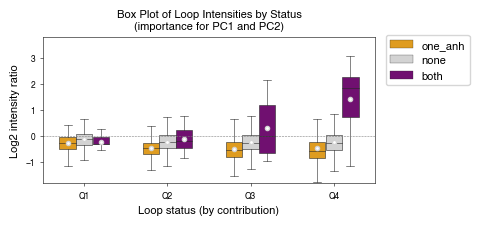

In [72]:
custom_palette = {
        'none': 'lightgrey',
        'one_anh': 'orange',        
        'both': 'purple'
    }
plt.figure(figsize=(5, 2.3))

df = merged_all_clusters
df = df[df.is_loop == True]
df = df[(df.log2_ratio <= 10) & (df.log2_ratio >= -10)]
df = df[["intensity_median", 'log2_ratio', 'importance_status_q', 'has_polycombDot_anchor_status_detailed', 'has_polycombDot_anchor']].drop_duplicates()

ax = sns.boxplot(x='importance_status_q', y='log2_ratio',
                hue="has_polycombDot_anchor_status_detailed",
                data=df,
                width=0.6,
                dodge=True,
                palette=custom_palette,
                 showmeans=True,
                 boxprops=dict(linewidth=0.4),
                 whiskerprops=dict(linewidth=0.4),
                 capprops=dict(linewidth=0.4),
                 medianprops=dict(linewidth=0.4),
                 meanprops={"marker": "o",
                            "markeredgecolor": "lightgrey",
                            "markerfacecolor": "white",
                            "markersize": "3"},
                 showfliers=False,                 
                 order=['Q1', "Q2", "Q3", 'Q4'])

ax.axhline(0, color='grey', linewidth=0.4, linestyle='--')
ax.legend(bbox_to_anchor=(1.3, 1.05))
plt.ylim(-1.8, 3.8)
plt.title('Box Plot of Loop Intensities by Status\n(importance for PC1 and PC2)')
plt.xlabel('Loop status (by contribution)')
plt.ylabel('Log2 intensity ratio')

plt.tight_layout()
save_name = "importance_groups_log2_intensity_ratio_horizontal"
plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")
plt.show()

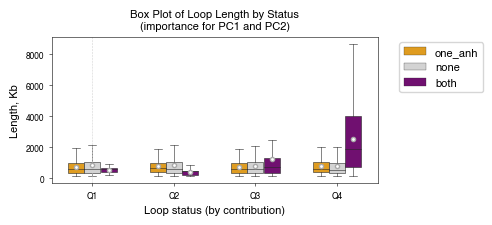

In [73]:
plt.figure(figsize=(5, 2.3)) 

df = merged_all_clusters
df = df[df.is_loop == True]
df = df[["intensity_median", 'length_kb', 'importance_status_q', 'has_polycombDot_anchor_status_detailed', 'has_polycombDot_anchor']].drop_duplicates()

ax = sns.boxplot(x='importance_status_q', y='length_kb',
                 hue="has_polycombDot_anchor_status_detailed",
                 showfliers=False,
                 data=df,
                 width = 0.6,
                 palette = custom_palette,
                 order=['Q1', "Q2", "Q3", "Q4"],
                 showmeans=True,
                 boxprops=dict(linewidth=0.4),
                 whiskerprops=dict(linewidth=0.4),
                 capprops=dict(linewidth=0.4),
                 medianprops=dict(linewidth=0.4),
                 meanprops={"marker": "o",
                            "markeredgecolor": "darkgrey",
                            "markerfacecolor": "white",
                            "markersize": "3"},
                 orient='v')  

ax.axvline(x=0, color='lightgrey', linestyle='--')
plt.title('Box Plot of Loop Length by Status\n(importance for PC1 and PC2)')
plt.xlabel('Loop status (by contribution)')
plt.ylabel('Length, Kb')

# Adjust legend position
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")
plt.show()

# 4. Explore Up-Down loops

## 4.1 Identify up- and down- loops

In [75]:
import math
def get_aggregated_list(xs):
    xs = list(xs)
    return [x for x in xs if x is not None]

def get_aggregated_list_unique(xs):
    xs = list(xs)
    return list(set([x for x in xs if x is not None]))

   
def get_cluster_data(merged_all_clusters_with_importance, col):
    assert merged_all_clusters_with_importance[merged_all_clusters_with_importance[col].isna()].shape[0] == 0
    unique_clusters = merged_all_clusters_with_importance['cluster'].unique()
    grouped = merged_all_clusters_with_importance.groupby(['cluster', 'group'])
    aggregated_data = grouped.agg({col: get_aggregated_list}).reset_index()
    assert aggregated_data.shape[0] == len(unique_clusters) * 2, "Aggregated data shape mismatch"
    cluster_all, t_stat_all, p_value_t_stat_all, mannwhitneyu_stat_all, p_value_mannwhitneyu_stat_all  = [], [], [], [], []    
    for cluster in tqdm(unique_clusters):
        current_cluster_data = aggregated_data[aggregated_data['cluster'] == cluster]    
        contrib_A = current_cluster_data[current_cluster_data['group'] == 'Post-mortem neurons'][col].iloc[0]
        contrib_B = current_cluster_data[current_cluster_data['group'] == 'iPSC-derived neurons'][col].iloc[0]
        
        try:
            mannwhitneyu_stat, p_value_mannwhitneyu_stat = mannwhitneyu(contrib_A, contrib_B, nan_policy ='omit') 
            t_stat, p_value_t_stat = ttest_ind(contrib_A, contrib_B, equal_var=False)  # Welch's t-test
        except:
            mannwhitneyu_stat, p_value_mannwhitneyu_stat= None, None
            t_stat, p_value_t_stat = None, None
            
        
        t_stat_all.append(t_stat)
        p_value_t_stat_all.append(p_value_t_stat)
        mannwhitneyu_stat_all.append(mannwhitneyu_stat)
        p_value_mannwhitneyu_stat_all.append(p_value_mannwhitneyu_stat)
        cluster_all.append(cluster)        
    
    result_df = pd.DataFrame({
        'cluster': cluster_all,
        't-statistic': t_stat_all,
        'p-value_t-statistics': p_value_t_stat_all,
        'mannwhitneyu_statistics': mannwhitneyu_stat_all,
        'p-value_mannwhitneyu-statistics': p_value_mannwhitneyu_stat_all
    })
    assert result_df['cluster'].nunique() == len(unique_clusters), "Unique clusters count mismatch"
    return result_df


def cluster_data_corrected(merged_all_clusters_with_importance, col = 'intensity_mean'):
    cluster_stats = get_cluster_data(merged_all_clusters_with_importance, col)
    merged_all_clusters_no_lu_with_stats = merged_all_clusters_with_importance.merge(cluster_stats, on = "cluster")

    return merged_all_clusters_no_lu_with_stats

def bedpe_to_bed_multiple_cols(df, ann_cols = ['num'], slope=0):
    """
    Extract unique bed regions from bedpe dataframe. Index is ignored.
    """
    df_reg1 = df[['chrom1', 'start1', 'end1'] + ann_cols].copy()
    df_reg1['anchor'] = 'left_anh'
    df_reg2 = df[['chrom2', 'start2', 'end2']+ann_cols ].copy()
    df_reg2['anchor'] = 'right_anh'
    df_reg1.columns = df_reg1.columns.str.rstrip('1')
    df_reg2.columns = df_reg2.columns.str.rstrip('2')

    df_bed = pd.concat([df_reg1, df_reg2], ignore_index=True)\
               .drop_duplicates(ignore_index=True)  
    df_bed.start = df_bed.start-slope
    df_bed.end = df_bed.end+slope
    return df_bed 

def run_go_diff_loops_2lists(genes, background, add_pathways=True, name= None):
    if name:
        print(f"Dataset - {name}")
    print(f"In gene_list - {len(genes)} genes, in the background - {len(background)}")
    gene_set = ['GO_Biological_Process_2021',
                'GO_Cellular_Component_2021',
                'GO_Molecular_Function_2021']
    if add_pathways:
        gene_set+=['MSigDB_Hallmark_2020','KEGG_2021_Human', 'PFOCR_Pathways_2023', "WikiPathway_2023_Human"]
    enr = gp.enrichr(gene_list=genes,
                     background=background,
                     gene_sets=gene_set,
                     organism='Human',
                     outdir=None, 
                    )
    return enr
    
def run_go_diff_loops(genes_in_important_clusters, genes_in_all_clusters, add_pathways=False, name= None):
    if name:
        print(f"Dataset - {name}")
    genes = genes_in_important_clusters[genes_in_important_clusters.gene_type_anno == "protein_coding"].gene_name_anno.unique().tolist()
    background = genes_in_all_clusters[genes_in_all_clusters.gene_type_anno == "protein_coding"].gene_name_anno.unique().tolist()
    print(f"In gene_list - {len(genes)} genes, in the background - {len(background)}")
    gene_set = ['GO_Biological_Process_2021',
                'GO_Cellular_Component_2021',
                'GO_Molecular_Function_2021']
    if add_pathways:
        gene_set+=['MSigDB_Hallmark_2020','KEGG_2021_Human', 'PFOCR_Pathways_2023', "WikiPathway_2023_Human"]
    enr = gp.enrichr(gene_list=genes,
                     background=background,
                     gene_sets=gene_set,
                     organism='Human',
                     outdir=None, 
                    )
    return enr

def get_dot_plot(enr: pd.DataFrame) -> None:
    # Filter results with Adjusted P-value < 0.05
    significant_results = enr.results.query('`Adjusted P-value` < 0.05')
    
    if significant_results.shape[0] > 0:
        # Print the significant terms
        for i, term in enumerate(significant_results.sort_values('Adjusted P-value').Term.tolist()):
            print(f"{i + 1}. {term}")        

        term_count = significant_results.shape[0]
        if term_count <= 4:
            height, width = 3, 5
        elif 4 < term_count < 9:
            height, width = 6, 7
        elif 9 <= term_count < 13:
            height, width = 9, 10
        else:
            height, width = 11, 13
        
        # Generate the dot plot
        ax = dotplot(
            significant_results,
            column="Adjusted P-value",
            x='Gene_set',  # Set x-axis for multi-sample/library comparison
            size=3,
            top_term=15,
            figsize=(width, height),
            title="GO",
            xticklabels_rot=45,  # Rotate x-tick labels
            show_ring=True,  # Set to False to remove outer ring
            marker='o',
        )
        plt.show()
    else:
        print('No enriched terms at Adjusted P-value < 0.05')
        

def identify_cluster_loops(dat_up_down, column, factor):
    data = dat_up_down.groupby(['cluster', 'group']).sum().reset_index()
    filtered_clusters = []
    for cluster in data.cluster.unique():
        df = data[data.cluster ==  cluster]    
        if df[df['group'] == column].is_loop.iloc[0] >=factor:
            filtered_clusters.append(cluster)
    return filtered_clusters

def get_genes_slope(bed_important_merged_all_clusters_with_importance_reduced, promoters, slope):
    genes_in_important_clusters = bf.overlap(bed_important_merged_all_clusters_with_importance_reduced, promoters, how='left', suffixes=('','_anno'))
    print(f"All genes - {genes_in_important_clusters.gene_name_anno.nunique()}")
    print(f'Protein - codings genes - {genes_in_important_clusters[genes_in_important_clusters.gene_type_anno == "protein_coding"].gene_name_anno.nunique()}')
    # genes_in_important_clusters = genes_in_important_clusters.groupby(['chrom', 'start', 'end']).agg({'gene_name_anno': to_list}).reset_index()
    if slope !=0:
        genes_in_important_clusters.start = genes_in_important_clusters.start+slope
        genes_in_important_clusters.end = genes_in_important_clusters.end-slope
    return genes_in_important_clusters
    
def get_genes_in_up_down(df_init, promoters, filter_only_loops = False, retain_loops_only = False, filter_only_loops_and_cluster = False,  stats_column = 't-statistic', p_value_column = 'q-value_t-statistics', p_value_cutoff = 0.05, slope=0):
    merged_all_clusters_no_lu_with_stats = df_init.copy()
    merged_all_clusters_no_lu_with_stats = merged_all_clusters_no_lu_with_stats[[stats_column, 'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'is_loop','cluster','source', 'contrib','status', 'length', 'group', 'p-value_mannwhitneyu-statistics','q-value_mannwhitneyu-statistics' ]].drop_duplicates()
    if filter_only_loops:
        deduplicated_clusters = merged_all_clusters_no_lu_with_stats[[stats_column, 'cluster', 'is_loop']].drop_duplicates()
        deduplicated_clusters = deduplicated_clusters[deduplicated_clusters.is_loop == True]
        deduplicated_clusters = deduplicated_clusters[stats_column].tolist()

    else:
        deduplicated_clusters = merged_all_clusters_no_lu_with_stats[[stats_column, 'cluster']].drop_duplicates()
        deduplicated_clusters = deduplicated_clusters[stats_column].tolist()        
        
    if stats_column == 't-statistic':
        lower_quantile = -0.0001
        upper_quantile = 0.0001
    elif stats_column == 'mannwhitneyu_statistics':
        lower_quantile = np.median(deduplicated_clusters)
        upper_quantile = np.median(deduplicated_clusters)        
    else:
        return 'invalid column'
    
    down_post_mortem = merged_all_clusters_no_lu_with_stats.loc[(merged_all_clusters_no_lu_with_stats[stats_column] <lower_quantile )&(merged_all_clusters_no_lu_with_stats[p_value_column] <= p_value_cutoff)]
    up_post_mortem = merged_all_clusters_no_lu_with_stats.loc[(merged_all_clusters_no_lu_with_stats[stats_column] > upper_quantile )&(merged_all_clusters_no_lu_with_stats[p_value_column] <= p_value_cutoff)]
    
    if filter_only_loops_and_cluster:
        factor_pm = round(merged_all_clusters_no_lu_with_stats[["source", "group"]].drop_duplicates().groupby('group').size()['Post-mortem neurons']*0.4, 0)
        factor_ipcs = round(merged_all_clusters_no_lu_with_stats[["source", "group"]].drop_duplicates().groupby('group').size()['iPSC-derived neurons']*0.4, 0)

        down_filtered_clusters = identify_cluster_loops(down_post_mortem, "iPSC-derived neurons",factor_ipcs)
        down_post_mortem = down_post_mortem[down_post_mortem.cluster.isin(down_filtered_clusters)]
        
        up_filtered_clusters = identify_cluster_loops(up_post_mortem,"Post-mortem neurons",factor_pm )
        up_post_mortem = up_post_mortem[up_post_mortem.cluster.isin(up_filtered_clusters)]       

    
    if filter_only_loops:
        down_post_mortem = down_post_mortem[down_post_mortem.is_loop == True]
        up_post_mortem = up_post_mortem[up_post_mortem.is_loop == True]

    merged_all_clusters_no_lu_with_stats_loops = merged_all_clusters_no_lu_with_stats.copy()
    
    if retain_loops_only:
        down_post_mortem = down_post_mortem[down_post_mortem.is_loop == True]
        up_post_mortem = up_post_mortem[up_post_mortem.is_loop == True]
        merged_all_clusters_no_lu_with_stats_loops = merged_all_clusters_no_lu_with_stats_loops[merged_all_clusters_no_lu_with_stats_loops.is_loop == True]
    
    print(f'There are {down_post_mortem.cluster.nunique()} clusters that are down in Post-mortem')
    print(f'There are {up_post_mortem.cluster.nunique()} clusters that are up in Post-mortem')
    bed_merged_all_clusters_no_lu_with_stats_loops = bedpe_to_bed_multiple_cols(merged_all_clusters_no_lu_with_stats_loops
        , ann_cols =['cluster', 'contrib','status', 'length', 'group', 'mannwhitneyu_statistics','p-value_mannwhitneyu-statistics','q-value_mannwhitneyu-statistics'], slope=slope)
    
    genes_in_all_clusters_no_lu_with_stats = get_genes_slope(bed_merged_all_clusters_no_lu_with_stats_loops, promoters, slope)
    genes_in_up_postmortem_clusters_no_lu_with_stats = get_genes_slope(bed_merged_all_clusters_no_lu_with_stats_loops[bed_merged_all_clusters_no_lu_with_stats_loops.cluster.isin(up_post_mortem.cluster.tolist())], promoters, slope)
    genes_in_dwn_postmortem_clusters_no_lu_with_stats = get_genes_slope(bed_merged_all_clusters_no_lu_with_stats_loops[bed_merged_all_clusters_no_lu_with_stats_loops.cluster.isin(down_post_mortem.cluster.tolist())], promoters, slope)
    
    
        
    return genes_in_all_clusters_no_lu_with_stats, genes_in_up_postmortem_clusters_no_lu_with_stats, genes_in_dwn_postmortem_clusters_no_lu_with_stats

def get_general_gene_intersect(df, additional_columns = ['cluster', 'contrib','status', 'length', 'group', 't-statistic', 'p-value']):    
    bed_merged = bedpe_to_bed_multiple_cols(df
        , ann_cols =additional_columns)
    genes_bed_merged = get_genes(bed_merged, promoters)
    return genes_bed_merged



In [107]:
merged_all_clusters.intensity_median = merged_all_clusters.intensity_median.fillna(10**-10)
cluster_data = get_cluster_data(merged_all_clusters[['cluster', 'group', 'source', 'intensity_median']].drop_duplicates().reset_index(drop=True), col = 'intensity_median')
merged_all_clusters['p-value_mannwhitneyu-statistics'] = merged_all_clusters['cluster'].map(dict(cluster_data[['cluster', 'p-value_mannwhitneyu-statistics']].values))
merged_all_clusters['mannwhitneyu_statistics'] = merged_all_clusters['cluster'].map(dict(cluster_data[['cluster', 'mannwhitneyu_statistics']].values))
cluster_data.head()

  5%|██████▊                                                                                                                       | 1199/22235 [00:09<02:49, 123.76it/s]/home/dzagirova/.local/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22235/22235 [02:46<00:00, 133.74it/s]


,cluster,t-statistic,p-value_t-statistics,mannwhitneyu_statistics,p-value_mannwhitneyu-statistics
0,chr1_1656,-2.176989,0.054696,6.0,0.073232
1,chr3_1689,-0.267101,0.795009,14.0,0.638889
2,chr15_613,-2.657305,0.028483,5.0,0.047980
3,chr3_1986,-4.832328,0.001801,0.0,0.002525
4,chr9_720,-0.017551,0.986467,14.0,0.638889


In [108]:
deduplicated_merged_all_clusters_stats = merged_all_clusters[["cluster",  'p-value_mannwhitneyu-statistics']].drop_duplicates()
_, fdr_corrected = fdrcorrection(deduplicated_merged_all_clusters_stats['p-value_mannwhitneyu-statistics'])
assert len(fdr_corrected) == len(deduplicated_merged_all_clusters_stats['p-value_mannwhitneyu-statistics'])
fdr_corrected_qtest = {i:k for i,k in zip(deduplicated_merged_all_clusters_stats.cluster.tolist(),fdr_corrected )}
merged_all_clusters['q-value_mannwhitneyu-statistics'] = merged_all_clusters['cluster'].map(fdr_corrected_qtest)


## 4.2 Intersect with genes

In [111]:
genes_in_all_clusters_mu, genes_in_up_postmortem_mu, genes_in_dwn_postmortem_mu = get_genes_in_up_down(merged_all_clusters,  promoters, filter_only_loops_and_cluster = True, retain_loops_only=True, stats_column = 'mannwhitneyu_statistics', p_value_column = 'q-value_mannwhitneyu-statistics', slope = 0)
up_enrichment_mu = run_go_diff_loops(genes_in_up_postmortem_mu, genes_in_all_clusters_mu, name = "Genes in anchors of loops with higher intensity in post-mortem samples")
dwn_enrichment_mu = run_go_diff_loops(genes_in_dwn_postmortem_mu, genes_in_all_clusters_mu,  name = "Genes in anchors of loops with higher intensity in cultural samples")

down_mu_clusters = set(genes_in_dwn_postmortem_mu.cluster.tolist())
up_mu_clusters = set(genes_in_up_postmortem_mu.cluster.tolist())

merged_all_clusters['status_by_mu'] = merged_all_clusters.cluster.apply(
    lambda x: 'down_in_post_mortem' if x in down_mu_clusters else 
    ('up_in_post_mortem' if x in up_mu_clusters else 'not_defined')
)

merged_all_clusters_stats_trueLoops['status_by_mu'] = merged_all_clusters_stats_trueLoops.cluster.apply(
    lambda x: 'down_in_post_mortem' if x in down_mu_clusters else 
    ('up_in_post_mortem' if x in up_mu_clusters else 'not_defined')
)

genes_in_all_clusters_mu[['gene_name_anno']].dropna().drop_duplicates().to_csv('./loops_data/loops_genes_data/background_genes_in_clusters_DownPostmortem_vs_iPSCderived.csv', index=False)
genes_in_up_postmortem_mu[['gene_name_anno']].dropna().drop_duplicates().to_csv('./loops_data/loops_genes_data/genes_in_clusters_UpPostmortem_vs_iPSCderived.csv', index=False)
genes_in_dwn_postmortem_mu[['gene_name_anno']].dropna().drop_duplicates().to_csv('./loops_data/loops_genes_data/genes_in_clusters_DownPostmortem_vs_iPSCderived.csv', index=False)


There are 2922 clusters that are down in Post-mortem
There are 1063 clusters that are up in Post-mortem
All genes - 18493
Protein - codings genes - 7682
All genes - 1917
Protein - codings genes - 839
All genes - 3828
Protein - codings genes - 1410
Dataset - Genes in anchors of loops with higher intensity in post-mortem samples
In gene_list - 839 genes, in the background - 7682
Dataset - Genes in anchors of loops with higher intensity in cultural samples
In gene_list - 1410 genes, in the background - 7682


# 5. Study log2FC ratio

In [123]:
def plot_dataframe_de_loops_simple(df_filtered2, column, name, xlims = [0.0,4]):    
    custom_palette = {
        'none': 'lightgrey',
        'one_anh': '#fda056',
        'both': '#5a3a86'
    }
    
    plt.figure(figsize=(4, 3))
    df_plot = df_filtered2[['cluster', 'length_kb', 'status_by_mu','log2_ratio', column]].drop_duplicates()
    df_plot = df_plot.dropna()
    hue_order = ['both', 'one_anh', 'none']
    alphas = {'both': 0.6, 'one_anh': 0.4, 'none': 0.2}
    
    ax = plt.gca()    
    for hue in hue_order[::-1]:
        legend = False if hue != 'none' else True
        df = df_plot[df_plot[column] == hue]
        sns.scatterplot(data=df, x="log2_ratio", y="length_kb",
                        hue=column,
                        palette=custom_palette,                        
                        ax=ax,
                        legend=True)
                        # alpha=alphas[hue])

    plt.title('Scatter Plot of Loop Length vs Log2 Ratio')
    plt.xlim(xlims[0], xlims[1])
    plt.legend(bbox_to_anchor=(1.3, 1.05))
    save_name = f"log2ratio_length_de_loops_{name}"
    plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")
    
    plt.show()

def plot_length(df, mode = "neuronal", ylim = 5400):    
    df = df[['length_kb', 'cluster', 'has_h3k27me3_peak_encode_anchor']].drop_duplicates()
    custom_palette = {
            'none': 'lightgrey',
            'one_anh': '#fda056',
            'both': '#5a3a86'
        }
    modes = df.has_h3k27me3_peak_encode_anchor.unique()
    cnt=0
    for mode1 in modes:
        for mode2 in modes[cnt:]:
            if mode1 != mode2:
                t_stat, p_value_t_stat = ttest_ind(df[df.has_h3k27me3_peak_encode_anchor == mode1].length_kb.tolist(), df[df.has_h3k27me3_peak_encode_anchor == mode2].length_kb.tolist(), equal_var=False) 
                print(mode1 , mode2)
                print(t_stat, p_value_t_stat )
                cnt+=1
            
    plt.figure(figsize=(3, 2.3)) 
    ax = sns.boxplot(x='has_h3k27me3_peak_encode_anchor', y='length_kb',
                     showfliers=False,
                     data=df,
                     width = 0.4,
                     palette = custom_palette,
                     order=['none', "one_anh", "both"],
                     showmeans=True,
                     boxprops=dict(linewidth=0.4),
                     whiskerprops=dict(linewidth=0.4),
                     capprops=dict(linewidth=0.4),
                     medianprops=dict(linewidth=0.4),
                     meanprops={"marker": "o",
                                "markeredgecolor": "darkgrey",
                                "markerfacecolor": "white",
                                "markersize": "3"},
                     )  
    
    plt.ylabel('Length, Kb')
    plt.ylim(-100, ylim )
    save_name = f"{mode}_loop_length_by_anchor_status"
    plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")
    plt.show


def plot_log2ratio(df, mode = "neuronal", ylim_min = -1.5, ylim = 5400):    
    df = df[['log2_ratio', 'cluster', 'has_h3k27me3_peak_encode_anchor']].drop_duplicates()
    custom_palette = {
            'none': 'lightgrey',
            'one_anh': '#fda056',
            'both': '#5a3a86'
        }
    modes = df.has_h3k27me3_peak_encode_anchor.unique()
    cnt=0
    for mode1 in modes:
        for mode2 in modes[cnt:]:
            if mode1 != mode2:
                t_stat, p_value_t_stat = ttest_ind(df[df.has_h3k27me3_peak_encode_anchor == mode1].log2_ratio.tolist(), df[df.has_h3k27me3_peak_encode_anchor == mode2].log2_ratio.tolist(), equal_var=False) 
                print(mode1 , mode2)
                print(t_stat, p_value_t_stat )
                cnt+=1
            
    plt.figure(figsize=(3, 2.3)) 
    ax = sns.boxplot(x='has_h3k27me3_peak_encode_anchor', y='log2_ratio',
                     showfliers=False,
                     data=df,
                     width = 0.4,
                     palette = custom_palette,
                     order=['none', "one_anh", "both"],
                     showmeans=True,
                     boxprops=dict(linewidth=0.4),
                     whiskerprops=dict(linewidth=0.4),
                     capprops=dict(linewidth=0.4),
                     medianprops=dict(linewidth=0.4),
                     meanprops={"marker": "o",
                                "markeredgecolor": "darkgrey",
                                "markerfacecolor": "white",
                                "markersize": "3"},
                     )  
    plt.ylim(ylim_min, ylim )
    save_name = f"{mode}_loop_log2_ratio_by_anchor_status"
    plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")
    plt.show()

In [112]:
df = merged_all_clusters.copy()
df = df[df.is_loop == True]
df = df[df.log2_ratio <= 10]
df = df[df.log2_ratio >= -10]
loops_cultural = df[df.status_by_mu == "down_in_post_mortem"]
loops_neuronal = df[df.status_by_mu == "up_in_post_mortem"]

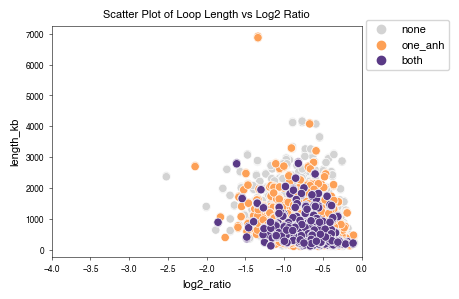

In [114]:
plot_dataframe_de_loops_simple(loops_cultural, 'has_h3k27me3_peak_encode_anchor', "down_in_pm", [-4.0, 0])

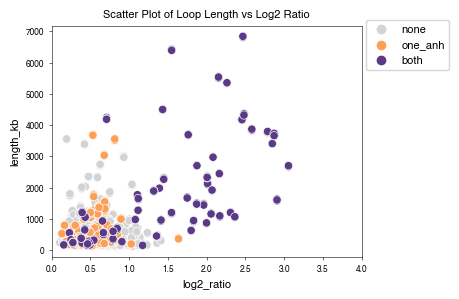

In [119]:
plot_dataframe_de_loops_simple(loops_neuronal, 'has_h3k27me3_peak_kozlenkov_anchor', "up_in_pm", [ 0, 4])

one_anh none
-5.624859500566742 1.9321330665936172e-08
one_anh both
3.3496613533663 0.0008362424659144679
none both
6.964163366679715 6.101173313084655e-12


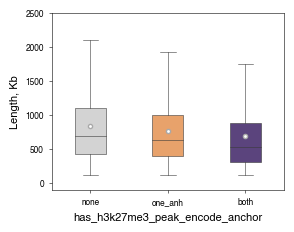

In [121]:
plot_length(loops_cultural.copy(), mode = "cultural", ylim = 2500)

one_anh none
-0.5096529632348359 0.6103462752983561
one_anh both
-9.149079084947774 9.926222460458889e-18
none both
-9.093241328829237 1.576044192221378e-17


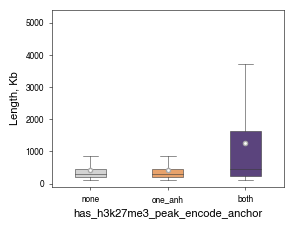

In [122]:
plot_length(loops_neuronal.copy(), mode = "neuronal")

one_anh none
-0.7673042351231593 0.4429842961956455
one_anh both
1.757074595667218 0.0798343134849358
none both
2.2337579104560024 0.026263410751636435


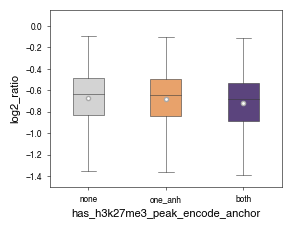

In [124]:
plot_log2ratio(loops_cultural.copy(), mode = "cultural", ylim = 0.15)

one_anh none
1.1973402465329248 0.23167119591773916
one_anh both
-7.039668791758156 2.0093826151871688e-10
none both
-7.401204169055615 4.2013802927735185e-11


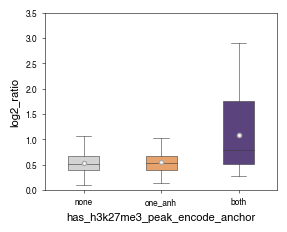

In [125]:
plot_log2ratio(loops_neuronal.copy(), mode = "neuronal", ylim_min = 0.0, ylim=3.5)

# 6. Analysis of TFs

In [180]:
df = merged_all_clusters.copy()
df = df[df.is_loop == True]
loops_cultural = df[df.status_by_mu == "down_in_post_mortem"]
loops_neuronal = df[df.status_by_mu == "up_in_post_mortem"]

In [144]:
def plot_violin_chart(df):
    custom_palette_tfs = {
        'no TFs': 'lightgrey',
        'contains TF': '#fda056',
        'both': '#7e65a1'
    }

    # Prepare data
    df_plot = df.copy()
    df_plot = df_plot[[
        "tf_in_cluster_status", 
        'log2FoldChange_promoters', 
        'has_h3k27me3_peak_kozlenkov_anchor', 
        'has_h3k27me3_peak_encode_anchor'
    ]].drop_duplicates()

    plt.figure(figsize=(5, 4))
    
    try:
        ax = sns.violinplot(
            y='log2FoldChange_promoters', 
            x='has_h3k27me3_peak_kozlenkov_anchor',
            hue="tf_in_cluster_status",
            data=df_plot,
            palette=custom_palette_tfs,
            alpha=1,
            width=1,
            linewidth=0.4, 
            split=True,
            gap=0.1,
            inner="box", 
            inner_kws={'marker': 'o', 'markersize': 4, 'box_width': 3, 'whis_width': 1},
            orient='v'
        )

        ax.axhline(y=0, color='grey', linestyle='--')        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.ylabel('Log2FC gene expression')
        plt.xlabel('H3K27me3 peak presence')

        plt.tight_layout()
        save_name = "de_neuronal_loops_tfs"
        plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")
       
        plt.show()

    except Exception as e:
        # Handle exceptions gracefully
        print(f"An error occurred while plotting: {e}")

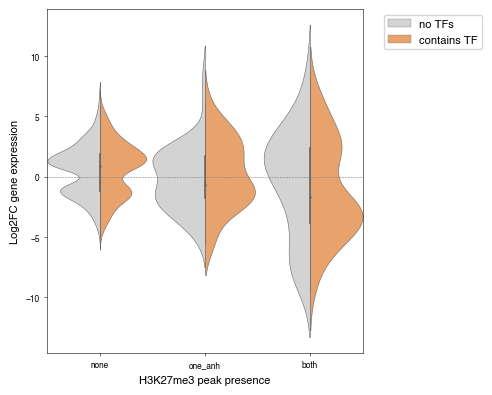

In [145]:
plot_violin_chart(loops_neuronal)

In [146]:
tf_stats = {}
for i in loops_neuronal.has_h3k27me3_peak_kozlenkov_anchor.unique():
    df = loops_neuronal[loops_neuronal.has_h3k27me3_peak_kozlenkov_anchor == i]
    unique_clusters = df.cluster.nunique()
    df = df[["tf_in_cluster_status", "cluster"]].drop_duplicates().groupby('tf_in_cluster_status').size()

    tf_stats[i] = {}
    tf_stats[i]['contains TF'] = round(df['contains TF'] /unique_clusters, 1)
    tf_stats[i]['no TFs'] =round( df['no TFs']/unique_clusters, 1)

In [147]:
def create_df_from_stats(tf_stats):
    df1 = pd.DataFrame(tf_stats).T[['contains TF']]
    df1.columns = ['percentage']
    df1['type'] = 'contains TF'
    df2 = pd.DataFrame(tf_stats).T[['no TFs']]
    df2.columns = ['percentage']
    df2['type'] = 'no TFs'
    df = pd.concat([df1,df2 ])
    df['Group'] = 'Up in Post-mortem'
    df = df.reset_index()
    df.columns = ['Peak', 'Value', "Type", "Group"]
    return df

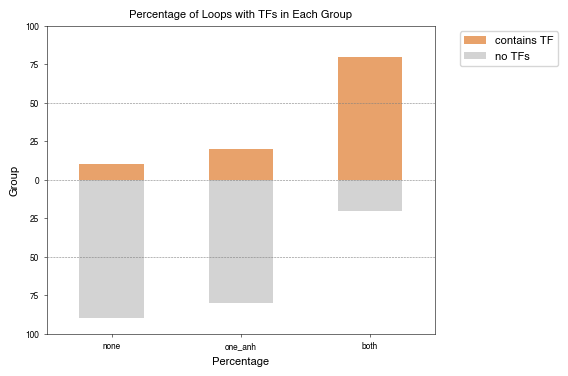

In [148]:
df = create_df_from_stats(tf_stats)
custom_palette = {
    'H3K27me3 consensus peak': "#8971ab",
    'H3K27me3 neuronal peak': "#034e91",
    'H3K27me3 cultural peak': "#469433",
    'No H3K27me3 peak': "lightgrey"
}

fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(
    x='Peak', y='Value', hue='Type', data=df[df['Type'] == 'contains TF'],
    palette = custom_palette_tfs, ax=ax,width =0.5,  orient='v', dodge=True,
)

sns.barplot(
    x='Peak', y=df['Value']*-1, hue='Type', data=df[df['Type'] == 'no TFs'],
    palette = custom_palette_tfs, ax=ax, width =0.5,  orient='v', dodge=True, 
)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], title='Peak')
ax.set_xlabel('Percentage')
ax.set_ylabel('Group')
ax.set_title('Percentage of Loops with TFs in Each Group')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axhline(y=0, color='grey', linestyle='--', zorder=10) 
ax.axhline(y=-0.5, color='grey', linestyle='--', zorder=10) 

ax.axhline(y=0.5, color='grey', linestyle='--', zorder=10) 
# Adjust x-axis to show positive values for both up and down
ax.set_ylim(-1, 1)
ax.set_yticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels([100, 75, 50, 25, 0, 25, 50, 75, 100])
save_name = "de_loops_tfs_neuronal_percentage"
plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")

plt.show()

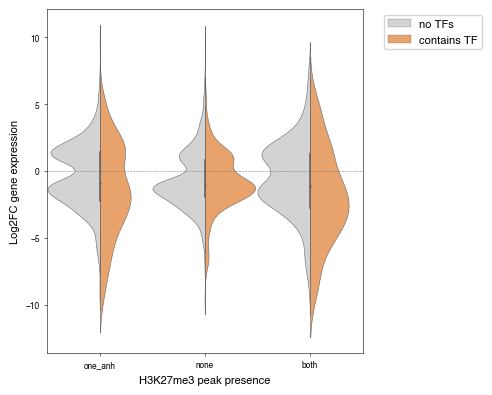

In [161]:
plt.figure(figsize=(5,4))
df_plot = loops_cultural.copy()
df_plot = df_plot[["tf_in_cluster_status", 'log2FoldChange_promoters', 'has_h3k27me3_peak_kozlenkov_anchor', 'has_h3k27me3_peak_encode_anchor']].drop_duplicates()
ax = sns.violinplot(y='log2FoldChange_promoters', x='has_h3k27me3_peak_encode_anchor',
                 hue="tf_in_cluster_status",
                 data=df_plot,
                palette = custom_palette_tfs,
                alpha=1,
                width = 1,
                linewidth=0.4, 
                split=True,
                gap=.1,
                 inner="box",
                inner_kws=dict(marker = 'o',markersize = "4",
                                   box_width=4, whis_width=1),
                 orient='v')  

ax.axhline(y=0, color='grey', linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Log2FC gene expression')
plt.xlabel('H3K27me3 peak presence')

plt.tight_layout()
save_name = "de_cultural_loops_tfs"
plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")
plt.show()

In [149]:
tf_stats = {}
for i in loops_cultural.has_h3k27me3_peak_encode_anchor.unique():
    df = loops_cultural[loops_cultural.has_h3k27me3_peak_encode_anchor == i]
    unique_clusters = df.cluster.nunique()
    df = df[["tf_in_cluster_status", "cluster"]].drop_duplicates().groupby('tf_in_cluster_status').size()

    tf_stats[i] = {}
    tf_stats[i]['contains TF'] = round(df['contains TF'] /unique_clusters, 1)
    tf_stats[i]['no TFs'] =round( df['no TFs']/unique_clusters, 1)
tf_stats

{'one_anh': {'contains TF': 0.3, 'no TFs': 0.7},
 'none': {'contains TF': 0.1, 'no TFs': 0.9},
 'both': {'contains TF': 0.4, 'no TFs': 0.6}}

In [152]:
tf_stats_reorder = {}
for key in ['none', 'one_anh', 'both']:
    tf_stats_reorder[key] = tf_stats[key]
tf_stats = tf_stats_reorder

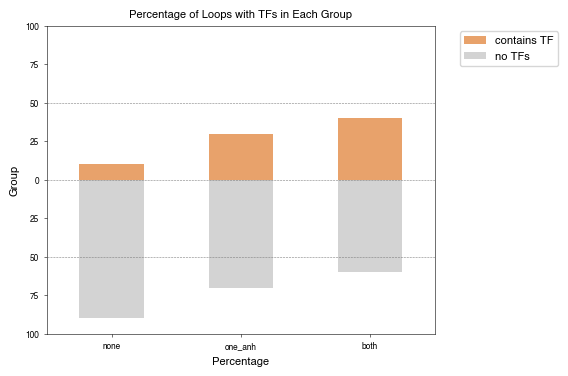

In [153]:
df = create_df_from_stats(tf_stats)

custom_palette = {
    'H3K27me3 consensus peak': "#8971ab",
    'H3K27me3 neuronal peak': "#034e91",
    'H3K27me3 cultural peak': "#469433",
    'No H3K27me3 peak': "lightgrey"
}

fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(
    x='Peak', y='Value', hue='Type', data=df[df['Type'] == 'contains TF'],
    palette = custom_palette_tfs, ax=ax,width =0.5,  orient='v', dodge=True,
)

sns.barplot(
    x='Peak', y=df['Value']*-1, hue='Type', data=df[df['Type'] == 'no TFs'],
    palette = custom_palette_tfs, ax=ax, width =0.5,  orient='v', dodge=True, 
)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], title='Peak')

# Set labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Group')
ax.set_title('Percentage of Loops with TFs in Each Group')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axhline(y=0, color='grey', linestyle='--', zorder=10) 
ax.axhline(y=-0.5, color='grey', linestyle='--', zorder=10) 

ax.axhline(y=0.5, color='grey', linestyle='--', zorder=10) 

# Adjust x-axis to show positive values for both up and down
ax.set_ylim(-1, 1)
ax.set_yticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels([100, 75, 50, 25, 0, 25, 50, 75, 100])
save_name = "de_loops_tfs_cultural_percentage"
plt.savefig(f"./loops_visualizations/{save_name}.pdf", bbox_inches='tight', format="pdf")

plt.show()

# 8. Save datasets and additional data

In [162]:
save_name = "loops_clustering_post_mortem_vs_iPSC_derived"
merged_all_clusters_stats_trueLoops.to_pickle(f"{path_to_loops_clusters_data}/{save_name}_merged_trueLoops_Properties.pickle")
merged_all_clusters.to_pickle(f"{path_to_loops_clusters_data}/{save_name}_merged_all_clusters_Properties.pickle")

In [176]:
#Genes in loops
merged_all_clusters_stats_trueLoops_pcGenes = merged_all_clusters_stats_trueLoops[merged_all_clusters_stats_trueLoops.gene_type_promoter == "protein_coding"]
merged_all_clusters_stats_trueLoops_pcGenes = merged_all_clusters_stats_trueLoops[merged_all_clusters_stats_trueLoops.gene_type_anno == "protein_coding"]
cultural_loops = merged_all_clusters_stats_trueLoops_pcGenes[merged_all_clusters_stats_trueLoops_pcGenes.status_by_mu == 'down_in_post_mortem']
cultural_loops[['gene_name_anno']].dropna().drop_duplicates()cultural_loops_loaded.to_csv(f'{path_to_loops_clusters_data}/cultural_loops_all.csv', index=False)

neuronal_loops = merged_all_clusters_stats_trueLoops_pcGenes[merged_all_clusters_stats_trueLoops_pcGenes.status_by_mu == 'up_in_post_mortem']
neuronal_loops[['gene_name_anno']].dropna().drop_duplicates().to_csv(f'{path_to_loops_clusters_data}/neuronal_loops_all.csv', index=False)


In [186]:
#TFs
tfs_down_loops = loops_cultural.loc[(loops_cultural.has_h3k27me3_peak_kozlenkov_anchor.isin(["none"])) & (loops_cultural.log2FoldChange <=-0.58) ]
tfs_down_loops = tfs_down_loops[tfs_down_loops.gene_name_anno.isin(tfs)]
tfs_down_loops.gene_name_anno.unique()
tfs_down_polycomb = loops_neuronal.loc[(loops_neuronal.has_h3k27me3_peak_kozlenkov_anchor == "both") & (loops_neuronal.log2FoldChange <=-0.58) ]
tfs_down_polycomb = tfs_down_polycomb[tfs_down_polycomb.gene_name_anno.isin(tfs)]
tfs_down_polycomb.gene_name_anno.nunique()

tfs_down_polycomb[['gene_name_anno']].dropna().drop_duplicates().to_csv(f'{path_to_loops_clusters_data}/tfs_down_polycomb.csv', index=False)
tfs_down_loops[['gene_name_anno']].dropna().drop_duplicates().to_csv(f'{path_to_loops_clusters_data}/tfs_down_loops.csv', index=False)
down_tfs = set(tfs) & set(all_expression_genes_medians[all_expression_genes_medians.log2FoldChange <= -0.58].gene_name.tolist())
pd.DataFrame(down_tfs, columns= ['gene_name_anno']).dropna().drop_duplicates().to_csv(f'{path_to_loops_clusters_data}/down_tfs.csv', index=False)
